# Exercício 7 - Radial Basis Functons Neural Networks 

**Aluno:** Vítor Gabriel Reis Caitité

**Matrícula:** $2021712430$

## Objetivos

O objetivo dos exercícios desta semana é implementar e testar uma rede neural RBF, com seleção automática de centros e raios, usando a técnica de k-médias. 

Para os primeiros testes, de classificação, devem ser geradas as seguintes bases de dados, utilizando o pacote em mlbench:

- mlbench.2dnormals(200)

- mlbench.xor(100)

- mlbench.circle(100)

- mlbench.spirals(100,sd = 0.05)

Para cada uma das bases, serão testados três valores de k (número de centros) para a função de k-médias. Assim como feito para o exercício de ELMs, a superfície de separação obtida para cada uma das redes deve ser mostrada no relatório.

A segunda parte desta atividade consiste em construir uma rede RBF para aproximar a função sinc acrescida de um ruído gaussiano:

- $sinc(x) = \frac{sin(x)}{x}$

Assim como feito para a primeira parte, serão ajustadas, pelo menos 3 redes RBF, com diferentes números de centros. As 3 redes terão seu desempenho comparado em um segundo conjunto de 50 amostras. A métrica a ser usada é o erro quadrático médio, definido como: 

- $MSE = \frac{1}{n} \sum^{n}_{i=1} (y_i − ŷ_i)^2$


## Importando Bibliotecas e Datasets

In [16]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
normals_dataset = pd.read_csv('data/normals.csv')
xor_dataset = pd.read_csv('data/xor.csv')
circle_dataset = pd.read_csv('data/circle.csv')
spirals_dataset = pd.read_csv('data/spirals.csv')

## Implementação da Rede RBF

In [3]:
import random
class RBF:
         
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
    
    def pdfnvar(self, x, m, K, n):
        if n==1:
            r = np.sqrt(K)
            px = (1/(math.sqrt(2*math.pi*r*r))) * math.e**(-0.5 * ((x - m)/r)**2)
        else:
            px = 1/math.sqrt((2*math.pi)**n * np.linalg.det(K)) * math.e ** (-0.5 * np.dot(np.dot(np.transpose(x - m), np.linalg.inv(K)), x-m))
        return px

    def fit(self, X, y):
        N = X.shape[0] # number of samples
        n = X.shape[1] # samples dimension
        # Applying K-mean to separate the clusters:
        kmeans = KMeans(n_clusters=self.n_neurons).fit(X)
        # Capture the centers:
        self.m = kmeans.cluster_centers_
        # Estimate the covariance matrix for all centers:
        self.cov_list = []
        for i in range(0, self.n_neurons):
            ici = np.where(kmeans.labels_ == i)
            Xci = X[ici, :].reshape(ici[0].shape[0], n)
            if n == 1:
                covi = np.var(Xci)
            else:
                covi = np.cov(Xci, rowvar=False) 
            self.cov_list.append(covi)      
        H = np.ones((N, self.n_neurons+1))
        for j in range(N):
            for i in range(self.n_neurons):
                mi = self.m[i,:]
                covi = self.cov_list[i] + 0.001 * np.diag(np.ones(n)) 
                H[j, i+1] = self.pdfnvar(X[j, ], mi, covi, n)
        self.W = np.dot(np.linalg.pinv(H), y)
        
    def predict(self, X):
        N = X.shape[0] # number of samples
        n = X.shape[1] # samples dimension
        H = np.ones((N, self.n_neurons+1))
        for j in range(N):
            for i in range(self.n_neurons):
                mi = self.m[i,:]
                covi = self.cov_list[i] + 0.001 * np.diag(np.ones(n)) 
                H[j, i+1] = self.pdfnvar(X[j, ], mi, covi, n)
        y_hat = np.dot(H, self.W)
        return y_hat

## Funções para captação de resultados e geração de gráficos

In [4]:
def plot_decision_border(X, y, clf, fig):
    #fig = plt.figure()
    ax = fig.add_subplot(121)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    #grid = normalizer.transform(grid)
    # make predictions for the grid
    yhat = (clf.predict(grid))
    yhat = np.array(yhat)
    yhat = (1*(yhat >= 0)-0.5)*2
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in [-1, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    #plt.show()  

In [5]:
def plot_surface(X, clf, fig):
    #fig = plt.figure()
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    ax = fig.add_subplot(122, projection='3d')
    # create grid to evaluate model
    x = np.linspace(min1, max1, 30)
    y = np.linspace(min2, max2, 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #xy = normalizer.transform(xy)
    Z=clf.predict(xy)
    Z = (1*(Z >= 0)-0.5)*2
    Z=np.array(Z).reshape(X.shape)
    # plot decision boundary and margins
    figure= ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    plt.show()

In [6]:
def results(X, y, p):
    train_accuracy = 0
    clf = RBF(p)
    clf.fit(X, y)
    y_hat_train=clf.predict(X)
    yt = (1*(y_hat_train >= 0)-0.5)*2
    train_accuracy = accuracy_score(y, yt)   
    
    print(f"*********** Resultado RBF com {p} neurônios na camada escondida **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy.mean())+ "+/-" + '{:.4f}'.format(train_accuracy.std()))
    fig = plt.figure(figsize=(11,5))
    plot_decision_border(X, y, clf, fig)
    plot_surface(X, clf, fig)
    

## Aplicação na base de dados mlbench.2dnormals(200)

Para essa base de dados buscou-se utilizar os valores de k como 1, 2 e 10. Afim de se poder observar um
solução com underfitting (para k=1), uma solução visualmente boa (para k = 2) e outra solução que já apresenta
sinais de overfitting (para k=10). As superfícies de separação obtidas para cada uma das 3 redes serão
mostradas abaixo.

*********** Resultado RBF com 1 neurônios na camada escondida **************
Acc train: 0.5200+/-0.0000


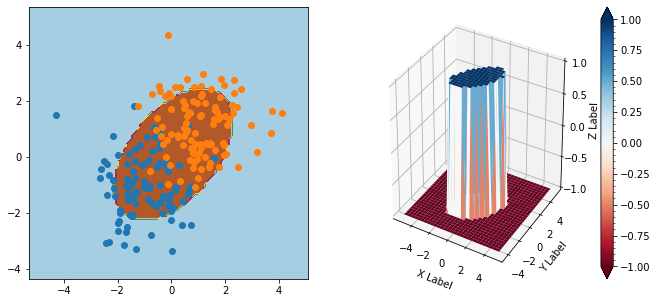

*********** Resultado RBF com 2 neurônios na camada escondida **************
Acc train: 0.9250+/-0.0000


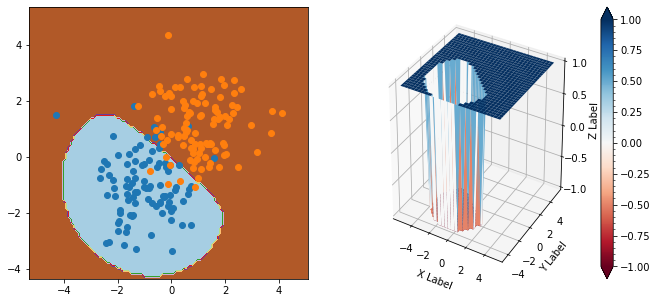

*********** Resultado RBF com 10 neurônios na camada escondida **************
Acc train: 0.9300+/-0.0000


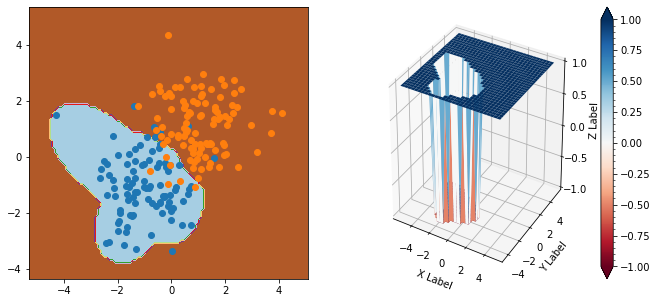

In [7]:
y = normals_dataset["classes"].astype(int).to_numpy()
y[y==2] = -1
X = normals_dataset.iloc[:,0:2].astype(float).to_numpy()
for p in [1, 2, 10]:
    results(X, y, p)
    

## Aplicação na base de dados mlbench.xor(100)

Já para a base de dados dados mlbench.xor utilizou-se os valores de k como 2, 4 e 10. Isso foi feito afim de se
poder observar um solução com underfitting (para k=2), uma solução visualmente boa (para k = 4) e outra solução
que já apresenta sinais de overfitting (para k=10). As superfícies de separação obtidas para cada uma das 3
redes serão mostradas abaixo.

*********** Resultado RBF com 2 neurônios na camada escondida **************
Acc train: 0.5000+/-0.0000


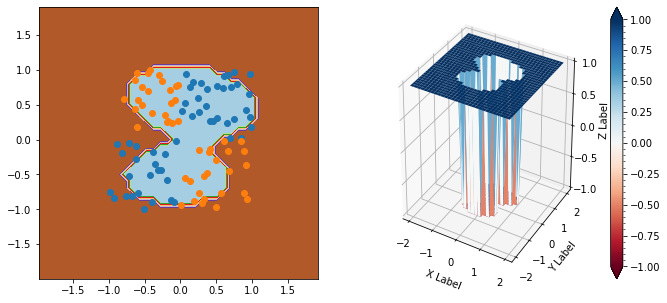

*********** Resultado RBF com 4 neurônios na camada escondida **************
Acc train: 0.9200+/-0.0000


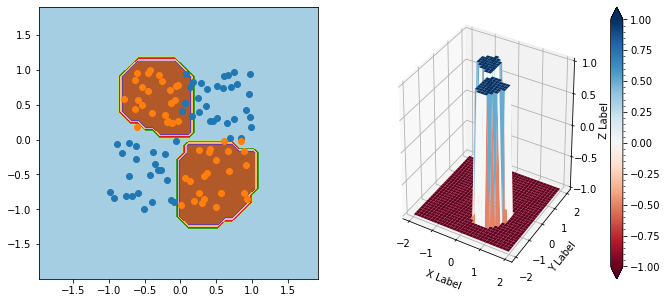

*********** Resultado RBF com 10 neurônios na camada escondida **************
Acc train: 0.9000+/-0.0000


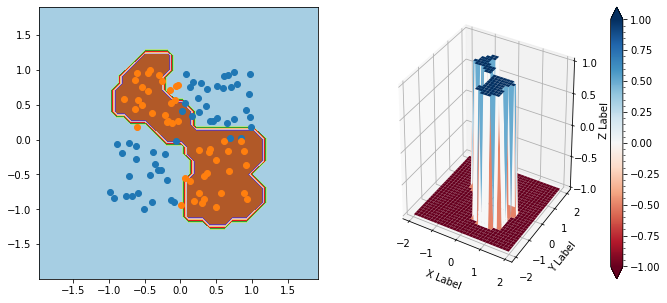

In [8]:
y = xor_dataset["classes"].astype(int).to_numpy()
y[y==2] = -1
X = xor_dataset.iloc[:,0:2].astype(float).to_numpy()
for p in [2, 4, 10]:
    results(X, y, p)

## Aplicação na base de dados mlbench.circle(100)

Para a base de dados dados mlbench.circle utilizou-se os valores de k como 5, 50 e 100. Isso foi feito afim de se
poder observar um solução com underfitting (para k=5), uma solução visualmente boa (para k = 50) e outra
solução que já apresenta sinais de overfitting (para k=100). As superfícies de separação obtidas para cada uma
das 3 redes serão mostradas abaixo.

*********** Resultado RBF com 5 neurônios na camada escondida **************
Acc train: 0.7025+/-0.0000


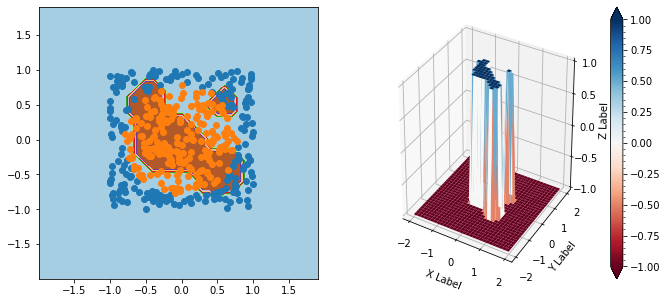

*********** Resultado RBF com 50 neurônios na camada escondida **************
Acc train: 0.9325+/-0.0000


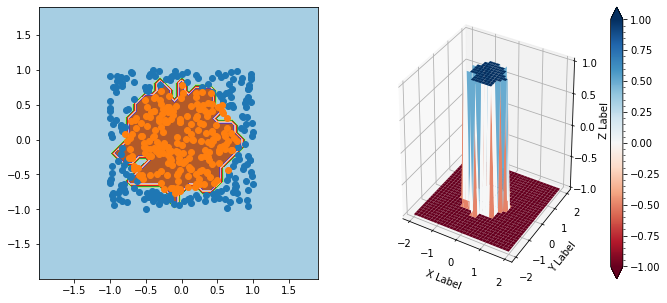

*********** Resultado RBF com 100 neurônios na camada escondida **************
Acc train: 0.9675+/-0.0000


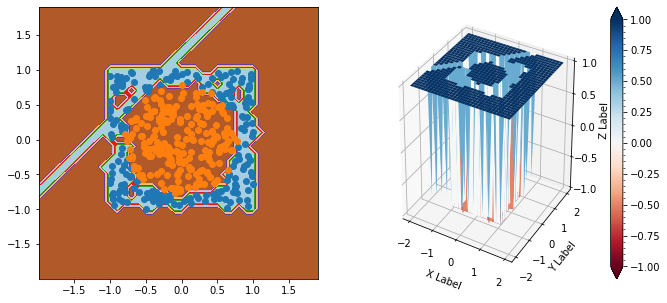

In [9]:
y = circle_dataset["classes"].astype(int).to_numpy()
y[y==2] = -1
X = circle_dataset.iloc[:,0:2].astype(float).to_numpy()
for p in [5, 50, 100]:
    results(X, y, p)

## Aplicação na base de dados mlbench.spirals(100)

Por fim, para a base de dados dados mlbench.spirals utilizou-se os valores de k como 15, 20 e 25. Isso foi feito afim de se poder observar um solução com underfitting (para k=15), uma solução visualmente boa (para k = 20) e outra solução que já apresenta sinais de overfitting (para k=40). As superfícies de separação obtidas para cada uma das 3 redes serão mostradas abaixo.

*********** Resultado RBF com 10 neurônios na camada escondida **************
Acc train: 0.7000+/-0.0000


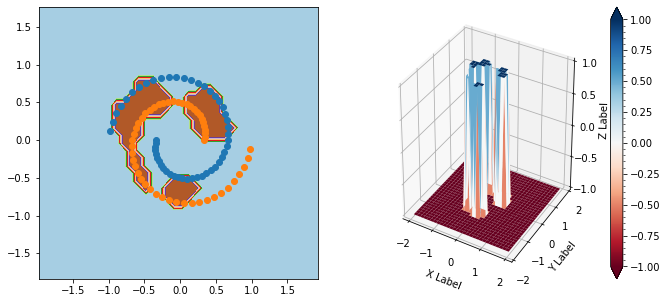

*********** Resultado RBF com 20 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000


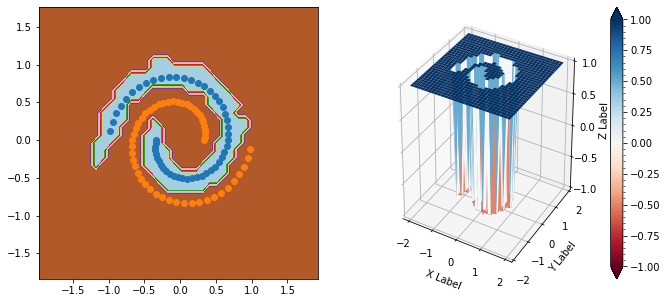

*********** Resultado RBF com 40 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000


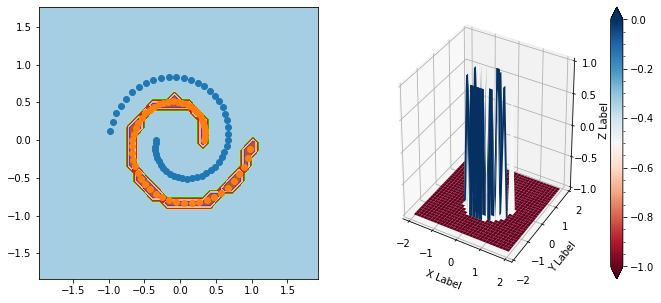

In [79]:
y = spirals_dataset["classes"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
for p in [10, 20, 40]:
    results(X, y, p)

## Aproximação da Função sinc(x) Utilizando Redes RBF

Erro quadrático médio para a RBF com 3 neurônios: MSE = 0.0334
Erro quadrático médio para a RBF com 8 neurônios: MSE = 0.0181
Erro quadrático médio para a RBF com 15 neurônios: MSE = 0.0247


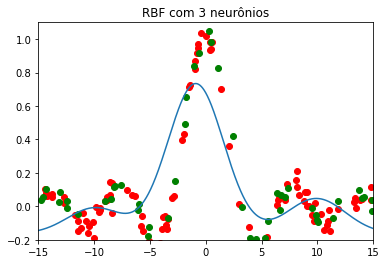

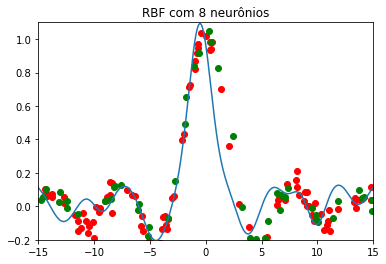

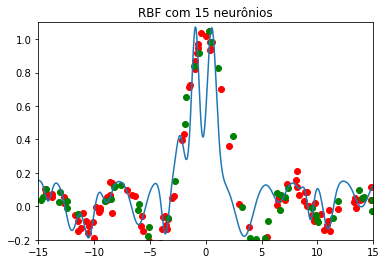

In [70]:
# Generating Data:
X = np.array([random.uniform(-15, 15) for i in range(150)]).reshape(150, 1)
y = np.zeros((150, 1))
rnorm = np.random.normal(loc=0.0, scale=0.05, size=150)
for i in range(150):
    y[i] = math.sin(X[i])/X[i] + rnorm[i]    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333)

# Training and Testing the Model:
for p in [3, 8, 15]:
    clf = RBF(p)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat = clf.predict(X_test)
    mse = sum((y_hat - y_test)**2)/y_test.shape[0]
    print(f"Erro quadrático médio para a RBF com {p} neurônios: MSE = " + '{:.4f}'.format(mse[0]))
    ax = plt.figure()
    plt.plot(X_train, y_train,"ro")
    plt.plot(X_test, y_test,"go")   
    x = np.linspace(-15,15,1000).reshape(1000, 1)
    y_hat = clf.predict(x).reshape(1000, 1)
    plt.plot(x, y_hat)  
    plt.title(f"RBF com {p} neurônios")
    plt.xlim(-15,15)
    plt.ylim(-0.2,1.1)

## Discussão:

Como pôde ser visto construiu-se uma rede RBF para aproximar a função sinc acrescida de um ruído gaussiano. Assim como feito para a primeira parte, foram ajustadas, 3 redes RBF, com diferentes números de
centros (3, 8 e 15). As 3 redes tiveram seu desempenho comparado em um segundo conjunto de 50 amostras (gerado da mesma forma que o primeiro). A métrica usada foi o erro quadrático médio. 

Notou-se que a rede RBF com 3 neurônios na camada escondida apresentou *underfitting* enquanto a rede RBF com 15 neurônios apresentou *overfitting*. Já a rede RBF com 8 neurônios apresentou uma boa solução, obtendo o menor erro quadrático (0.0181).